# Plant performance analysis 

# Importing libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib
import pytz

# Importing weather data

In [31]:
Weather_data = pd.read_csv("Hourly_20190101_20191231_014d93N_077d90E_LST.csv")

In [32]:
Weather_data.head()

,YEAR,MO,DY,HR,DHI,DNI,GHI,DBT,WS
0,2019,1,1,0,0.0,0.0,0.0,20.75,2.50
1,2019,1,1,1,0.0,0.0,0.0,20.51,2.26
2,2019,1,1,2,0.0,0.0,0.0,20.25,1.84
3,2019,1,1,3,0.0,0.0,0.0,20.12,1.64
4,2019,1,1,4,0.0,0.0,0.0,20.02,1.57


# Indexing the proper datetime format

In [33]:
rng = pd.date_range('1/1/2019', periods=8760, freq='H',tz=pytz.FixedOffset(330))

In [34]:
Weather_data= Weather_data.set_index(rng)

In [35]:
Weather_data.head()

,YEAR,MO,DY,HR,DHI,DNI,GHI,DBT,WS
2019-01-01 00:00:00+05:30,2019,1,1,0,0.0,0.0,0.0,20.75,2.50
2019-01-01 01:00:00+05:30,2019,1,1,1,0.0,0.0,0.0,20.51,2.26
2019-01-01 02:00:00+05:30,2019,1,1,2,0.0,0.0,0.0,20.25,1.84
2019-01-01 03:00:00+05:30,2019,1,1,3,0.0,0.0,0.0,20.12,1.64
2019-01-01 04:00:00+05:30,2019,1,1,4,0.0,0.0,0.0,20.02,1.57


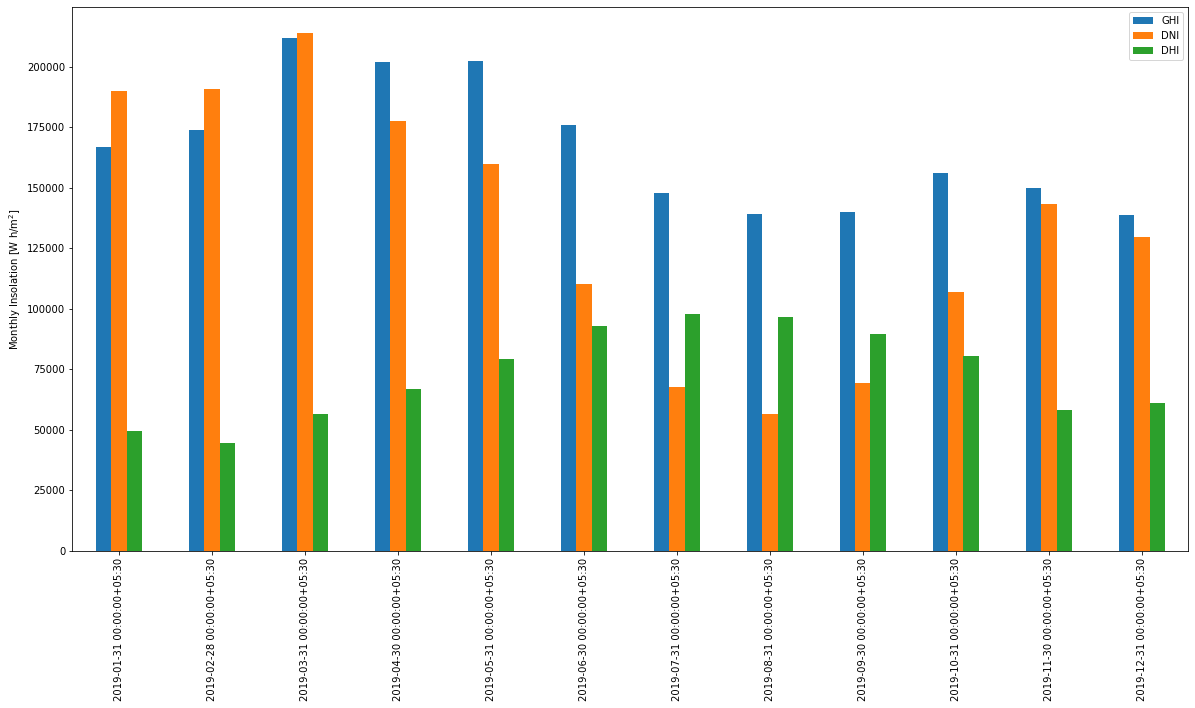

In [36]:
df = pd.DataFrame({
    'GHI': Weather_data['GHI'],
    'DNI': Weather_data['DNI'],
    'DHI': Weather_data['DHI']
})
df_monthly = df.resample('M').sum()
df_monthly.plot.bar(figsize=(20, 10))
plt.ylabel('Monthly Insolation [W h/m$^2$]');

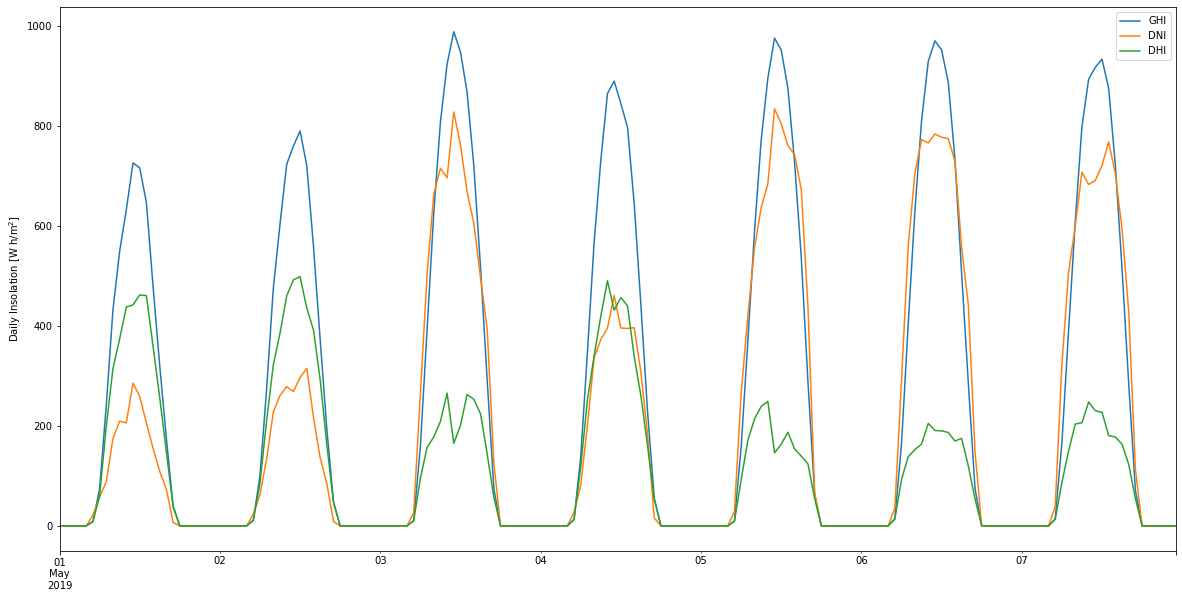

In [37]:
df = pd.DataFrame({
    'GHI': Weather_data['GHI'],
    'DNI': Weather_data['DNI'],
    'DHI': Weather_data['DHI']
})
df.loc['2019-05-01':'2019-05-07'].plot.line(figsize=(20, 10))
plt.ylabel('Daily Insolation [W h/m$^2$]');

# Plant Location

In [38]:
latitude=14.93
longitude=77.9
location = pvlib.location.Location(latitude=latitude,
                                   longitude=longitude)

In [39]:
# Note: weather datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = Weather_data.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2019-01-01 00:00:00+05:30,165.380171,165.380171,-75.380171,-75.380171,234.285636,-3.076829
2019-01-01 01:00:00+05:30,171.631033,171.631033,-81.631033,-81.631033,166.443649,-3.096690
2019-01-01 02:00:00+05:30,161.911595,161.911595,-71.911595,-71.911595,119.264560,-3.116542
2019-01-01 03:00:00+05:30,148.642817,148.642817,-58.642817,-58.642817,109.943330,-3.136387
2019-01-01 04:00:00+05:30,134.911346,134.911346,-44.911346,-44.911346,107.833380,-3.156224


# Fixed Tilt POA modeling

In [40]:
df_poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=15,  # tilted 20 degrees from horizontal
    surface_azimuth=180,  # facing South
    dni=Weather_data['DNI'],
    ghi=Weather_data['GHI'],
    dhi=Weather_data['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic')

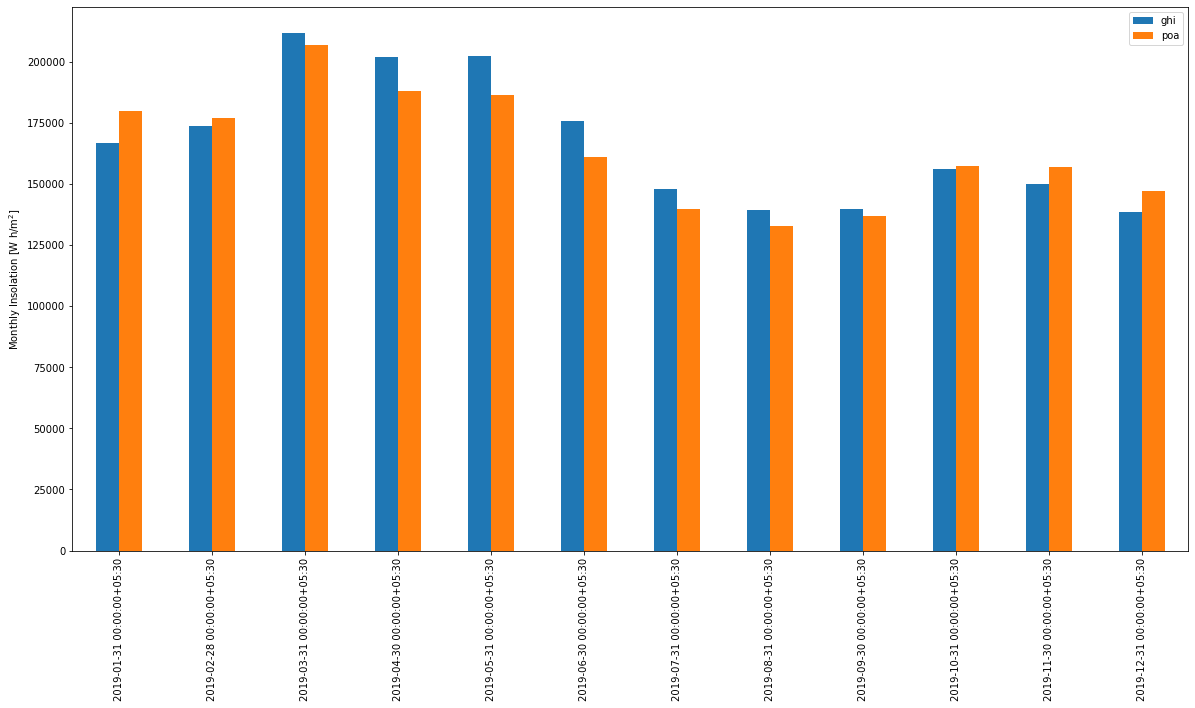

In [41]:
df = pd.DataFrame({
    'ghi': Weather_data['GHI'],
    'poa': df_poa['poa_global'],
})
df_monthly = df.resample('M').sum()
df_monthly.plot.bar(figsize=(20, 10))
plt.ylabel('Monthly Insolation [W h/m$^2$]');

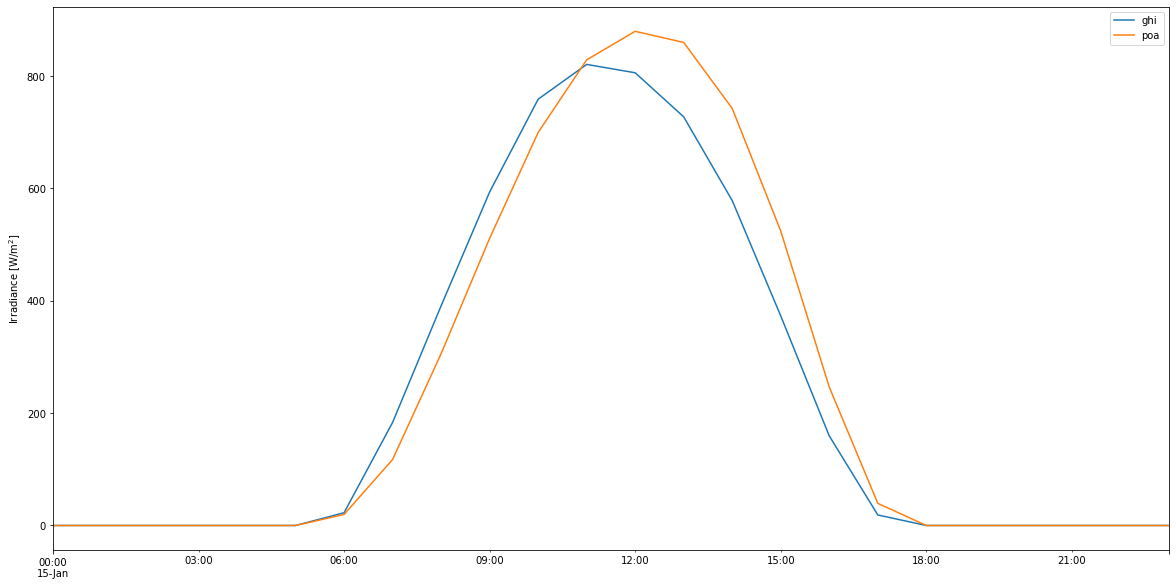

In [42]:
df.loc['2019-01-15'].plot(figsize=(20, 10))
plt.ylabel('Irradiance [W/m$^2$]');

# Single axis tracker modeling

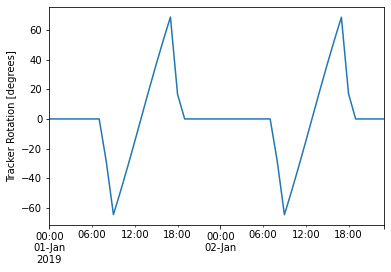

In [43]:
tracker_data = pvlib.tracking.singleaxis(
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    axis_azimuth=180,  # axis is aligned N-S
    )  # leave the rest of the singleaxis parameters like backtrack and gcr at their defaults
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

# plot a day to illustrate:
tracker_data['tracker_theta'].fillna(0).head(48).plot()
plt.ylabel('Tracker Rotation [degrees]');

In [44]:
df_poa_tracker = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,  # time series for tracking array
    surface_azimuth=azimuth,  # time series for tracking array
    dni=Weather_data['DNI'],
    ghi=Weather_data['GHI'],
    dhi=Weather_data['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

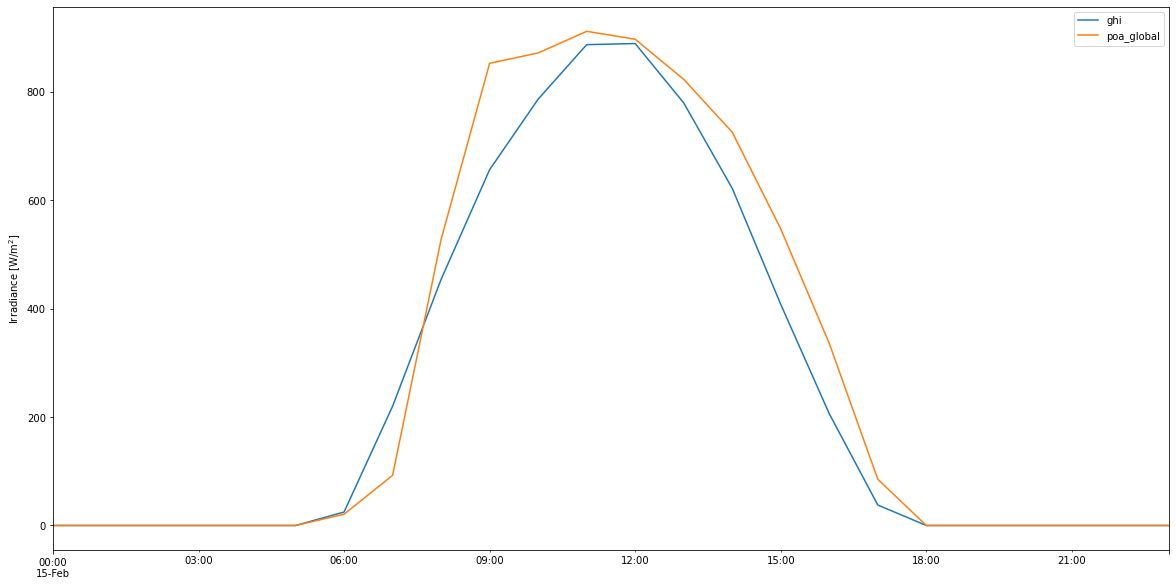

In [45]:
df.loc['2019-02-15', 'ghi'].plot(figsize=(20, 10))
tracker_poa.loc['2019-02-15'].plot(figsize=(20, 10))
plt.legend()
plt.ylabel('Irradiance [W/m$^2$]');

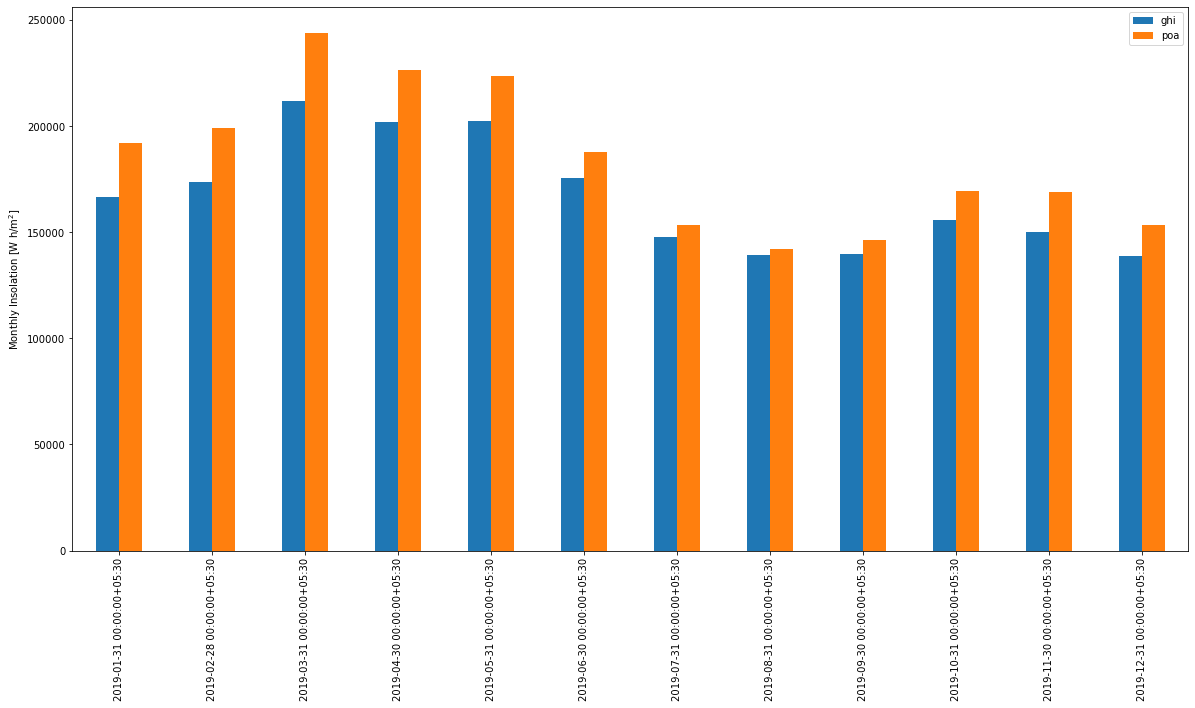

In [46]:
df = pd.DataFrame({
    'ghi': Weather_data['GHI'],
    'poa': df_poa_tracker['poa_global'],
})
df_monthly = df.resample('M').sum()
df_monthly.plot.bar(figsize=(20, 10))
plt.ylabel('Monthly Insolation [W h/m$^2$]');

# Panel Temperature modeling

In [47]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

In [48]:
parameters = all_parameters['open_rack_glass_polymer']
# note the "splat" operator "**" which expands the dictionary "parameters"
# into a comma separated list of keyword arguments
cell_temperature = pvlib.temperature.sapm_cell(
    tracker_poa, Weather_data['DBT'], Weather_data['WS'], **parameters)

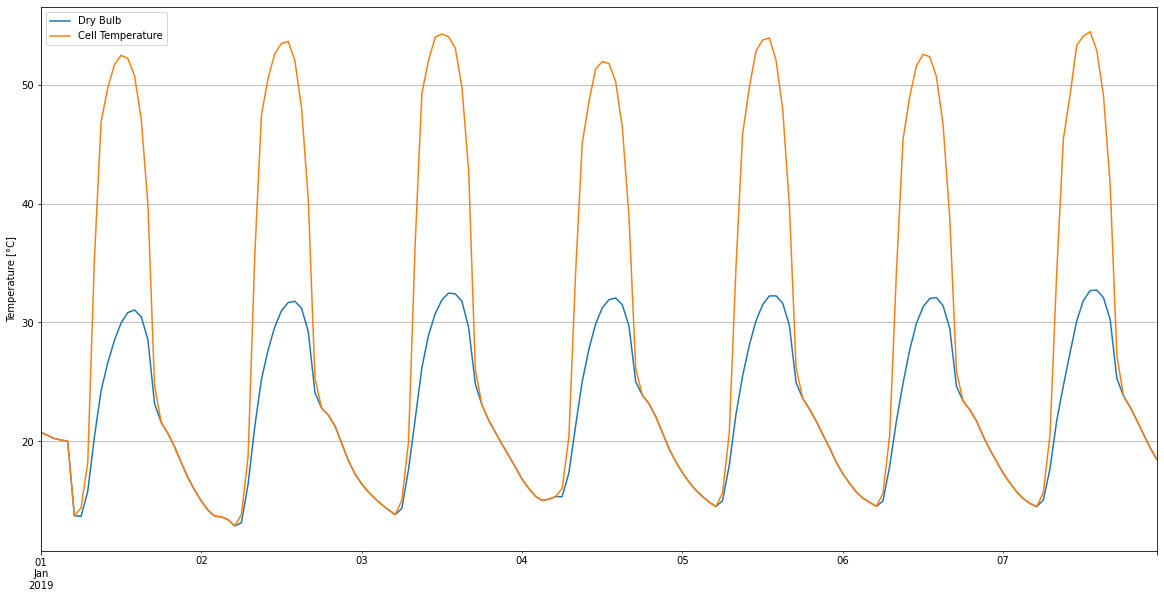

In [49]:
Weather_data['DBT'].head(24*7).plot(figsize=(20, 10))
cell_temperature.head(24*7).plot(figsize=(20, 10))
plt.grid()
plt.legend(['Dry Bulb', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

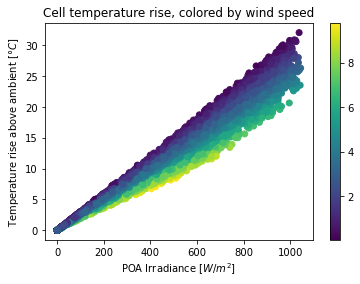

In [50]:
temperature_difference = cell_temperature - Weather_data['DBT']
plt.scatter(tracker_poa, temperature_difference, c=Weather_data['WS'])
plt.colorbar()
# note you can use LaTeX math in matplotlib labels
# compare \degree" with the unicode symbol above
plt.ylabel('Temperature rise above ambient [$\degree C$]')
plt.xlabel('POA Irradiance [$W/m^2$]');
plt.title('Cell temperature rise, colored by wind speed');

# Array Power

1kW array with a temperature coefficient of -0.4%/°C

In [51]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1e3

array_power_Tracker = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, gamma_pdc)

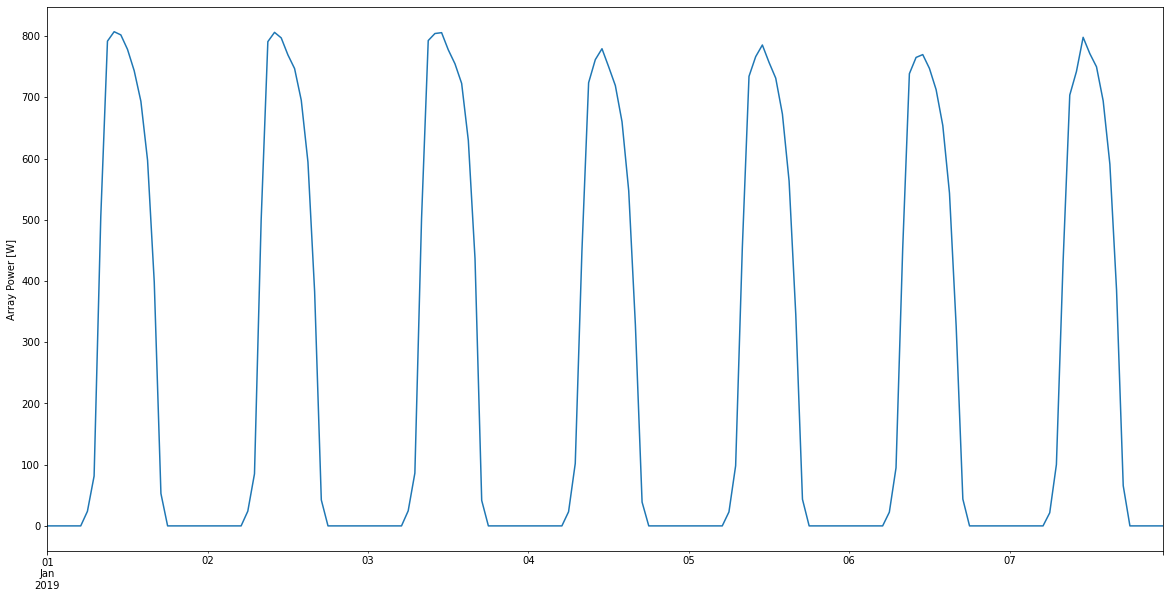

In [53]:
array_power_Tracker.head(24*7).plot(figsize=(20, 10))
plt.ylabel('Array Power [W]');

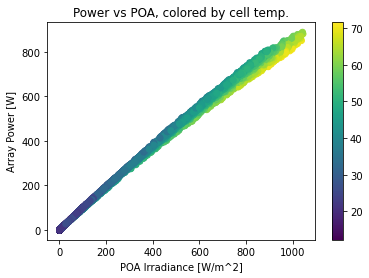

In [57]:
plt.scatter(tracker_poa, array_power_Tracker, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

# monthly energy production Vs monthly POA insolation

Text(0, 0.5, 'Energy [Wh]')

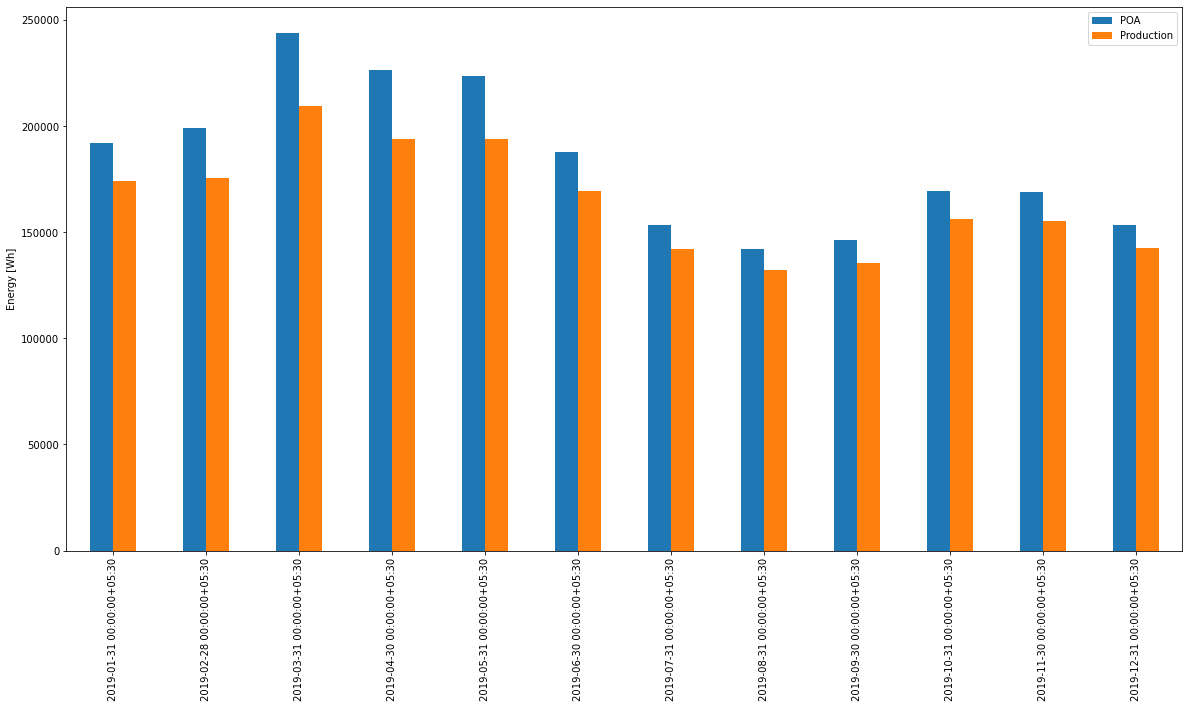

In [59]:
df_plot = pd.DataFrame({
    'POA': tracker_poa,
    'Production': array_power_Tracker,
})
# summing hourly power (W) gives (W h)
df_plot.resample('M').sum().plot.bar(figsize=(20, 10))
plt.ylabel('Energy [Wh]')

# AC/DC

assumed a 1kW array, so we'll continue the hypothetical case and assume an AC size of 800W, a DC/AC ratio of 1.2. The default PVWatts nominal inverter efficiency is 0.96 which we use to get pdc0.

In [61]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power_Tracker, pdc0)

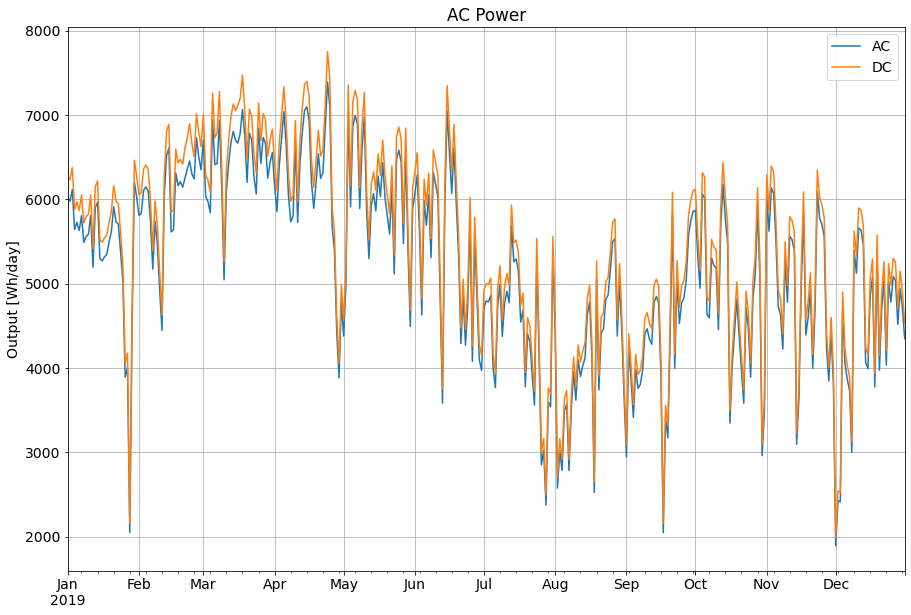

In [62]:
plt.rcParams['font.size'] = 14
ax = ac.resample('D').sum().plot(figsize=(15, 10), label='AC')
array_power_Tracker.resample('D').sum().plot(ax=ax, label='DC')
plt.title('AC Power')
plt.ylabel('Output [Wh/day]')
plt.grid()
plt.legend()